# Modeling & Evaluation

- Train baseline models
- Compare performance
- Evaluate using ROC-AUC and PR-AUC

Import


In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
    classification_report,
    confusion_matrix,
    f1_score,
    ConfusionMatrixDisplay
    )

import matplotlib.pyplot as plt
import shap

In [18]:

def eval_model(name, y_true, y_pred, y_proba):
    roc = roc_auc_score(y_true, y_proba)
    pr = average_precision_score(y_true, y_proba)  # PR-AUC (Average Precision)
    acc = accuracy_score(y_true, y_pred)
    print(f"\n{name}")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  ROC-AUC   : {roc:.4f}")
    print(f"  PR-AUC(AP): {pr:.4f}")

In [19]:
X_train, X_test, y_train, y_test = joblib.load("../data/splits.pkl")


Logisic Regression (Baseline)

In [20]:
log_model = LogisticRegression(max_iter = 5000)
log_model.fit(X_train,y_train)

y_pred_log = log_model.predict(X_test)
y_proba_log = log_model.predict_proba(X_test)[:,1]

eval_model("Logistic Regression", y_test, y_pred_log, y_proba_log)


Logistic Regression
  Accuracy : 0.8024
  ROC-AUC   : 0.8387
  PR-AUC(AP): 0.6572


Random Forest

In [21]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train,y_train)

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:,1]

eval_model("Random Forrest",y_test,y_pred_rf,y_proba_rf)




Random Forrest
  Accuracy : 0.7925
  ROC-AUC   : 0.8226
  PR-AUC(AP): 0.6212


XGBoost


In [23]:
xgb_model = XGBClassifier(
    eval_metric ="logloss",
    random_state = 42
)
xgb_model.fit(X_train,y_train)

y_pred_xgb=xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:,1]

eval_model("XGBoost",y_test,y_pred_xgb,y_proba_xgb)



XGBoost
  Accuracy : 0.7655
  ROC-AUC   : 0.8126
  PR-AUC(AP): 0.5947


ROC Curve


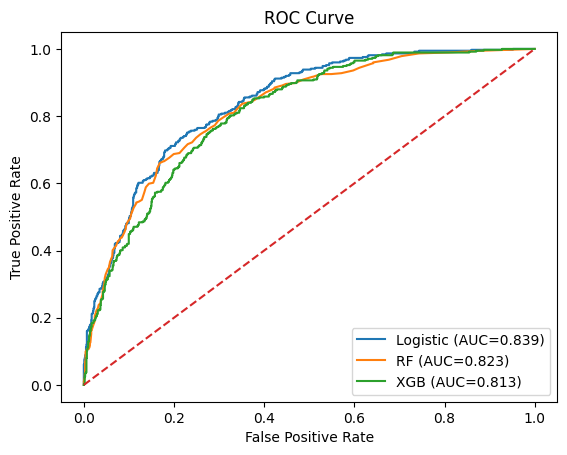

In [25]:
plt.figure()
for name, proba in [
    ("Logistic", y_proba_log),
    ("RF", y_proba_rf),
    ("XGB", y_proba_xgb),
]:
    fpr, tpr, _ = roc_curve(y_test, proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, proba):.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

PR Curve

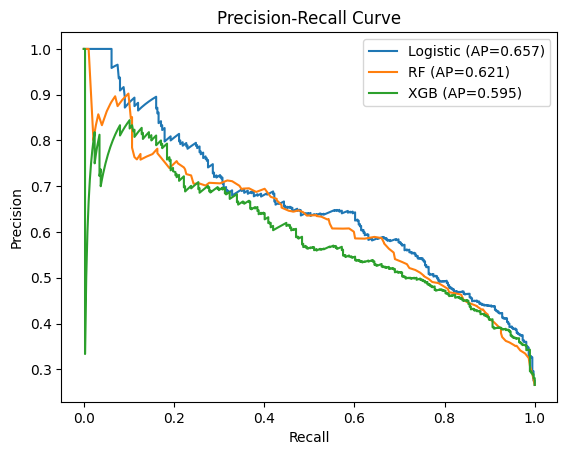

In [26]:
plt.figure()
for name, proba in [
    ("Logistic", y_proba_log),
    ("RF", y_proba_rf),
    ("XGB", y_proba_xgb),
]:
    precision, recall, _ = precision_recall_curve(y_test, proba)
    ap = average_precision_score(y_test, proba)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

Confusion Matris(XGB)

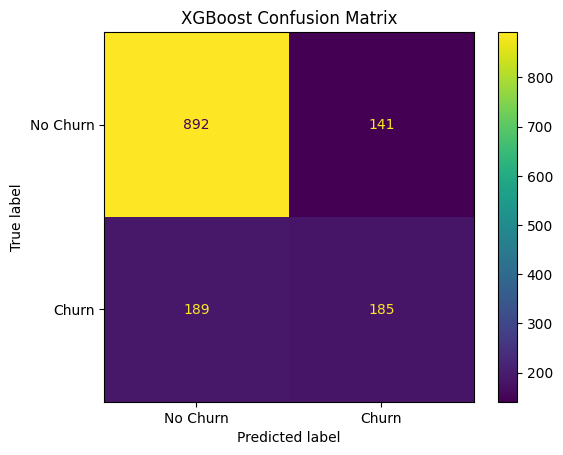

In [30]:
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_xgb,
    display_labels=["No Churn", "Churn"]
)
plt.title("XGBoost Confusion Matrix")
plt.show()

Threshold Tuning

In [34]:

thresholds = np.arange(0.1,0.9,0.01)

best_f1 = 0
best_thresh = 0

for t in thresholds:
    preds = (y_proba_xgb >= t).astype(int)
    f1 = f1_score(y_test,preds)
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = t

print("Best threshold:",best_thresh)
print("Best F1:",best_f1)

Best threshold: 0.23999999999999994
Best F1: 0.5963791267305645


New confusion matris for new threshold

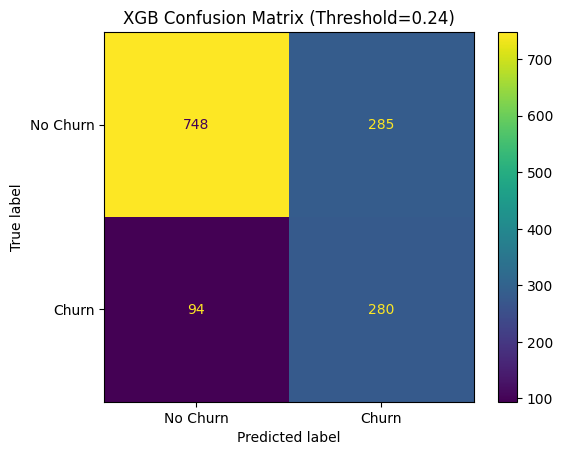

In [46]:
best_preds =(y_proba_xgb >= best_thresh).astype(int)

ConfusionMatrixDisplay.from_predictions(
    y_test,
    best_preds,
    display_labels=["No Churn","Churn"]
)
plt.title(f"XGB Confusion Matrix (Threshold={best_thresh:.2f})")
plt.show()


# XGBoost Feature Importance

In [37]:
importance = pd.Series(
    xgb_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance.head(15)

InternetService_Fiber optic       0.412516
Contract_Two year                 0.169956
HasInternet                       0.115858
Contract_One year                 0.089609
tenure                            0.021549
StreamingMovies_Yes               0.017562
OnlineSecurity_Yes                0.014343
PhoneService_Yes                  0.013021
PaymentMethod_Electronic check    0.012609
MultipleLines_Yes                 0.012435
TotalCharges                      0.010024
TechSupport_Yes                   0.009973
StreamingTV_Yes                   0.009932
OnlineBackup_Yes                  0.009779
PaperlessBilling_Yes              0.009561
dtype: float32

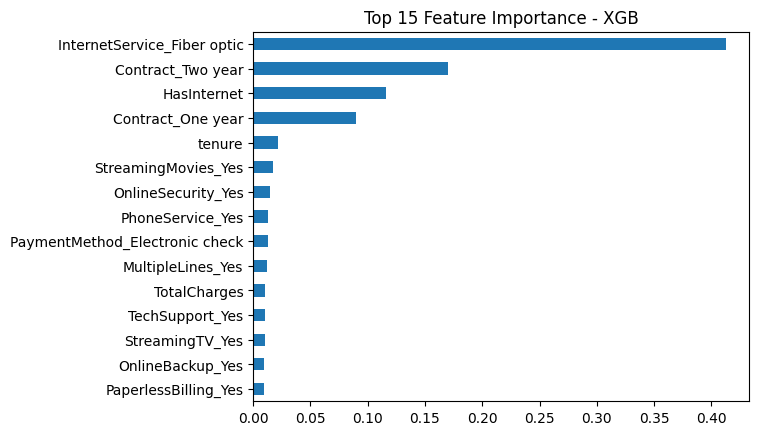

In [42]:
importance.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importance - XGB")
plt.show()

SHAP Analysis

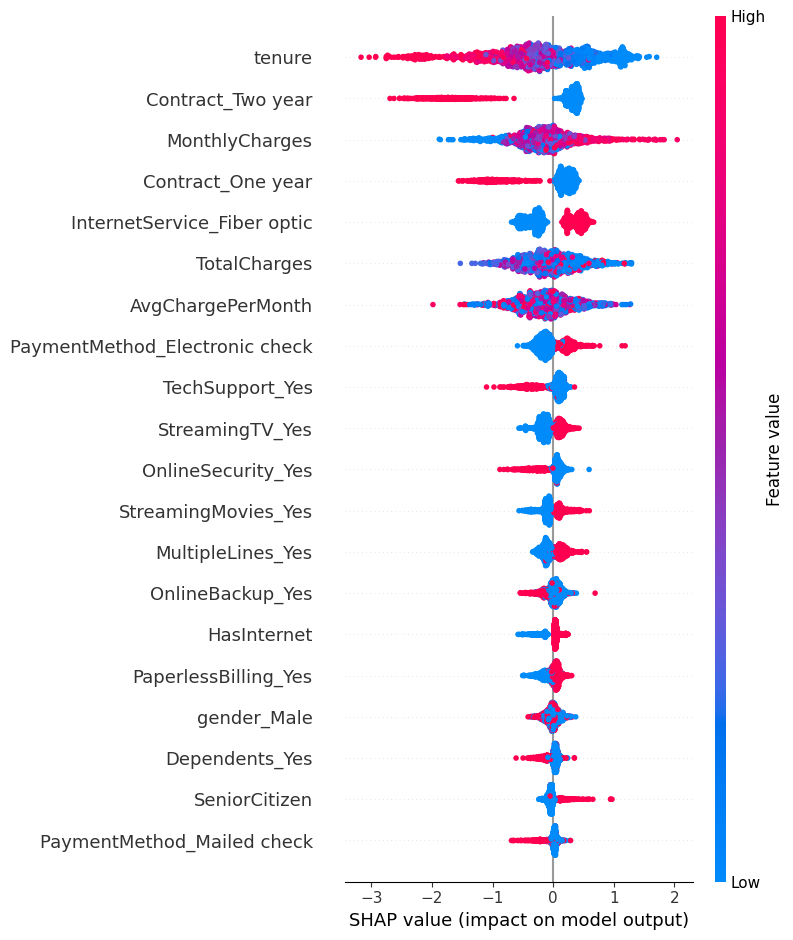

In [44]:
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values,X_test)

# Business Impact

In [47]:
tn,fp,fn,tp = confusion_matrix(y_test,y_pred_xgb).ravel()

cost_05 = (fn *300) + ((tp+fp) * 50)
print("Cost at 0.5 threshold:",cost_05)

Cost at 0.5 threshold: 73000


In [49]:
tn, fp, fn, tp = confusion_matrix(y_test, best_preds).ravel()

cost_best = (fn * 300) + ((tp + fp) * 50)
print("Cost at 0.24 threshold:", cost_best)

Cost at 0.24 threshold: 56450


TOP-K Analysis for K=300

In [ ]:
def topk_metrics(y_true,y_proba,k):
    top_idx = np.argsort(-y_proba)[:k]
    y_top = y_true.iloc[top_idx]

    churn_in_topk = int(y_top.sum())
    precision_at_k = float(y_top.mean())
    recall_at_k = float(y_top.sum()/y_true.sum())

   return churn_in_topk, precision_at_k, recall_at_k

